### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 26.9 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 36s


А теперь в 3 строчки обучим нашу модель

In [11]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

In [14]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 3),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 3),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
from gensim.models import LdaModel

In [16]:
LdaModel

gensim.models.ldamodel.LdaModel

In [17]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 46.8 s


In [18]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [19]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(7, 0.69393986), (18, 0.06892464), (23, 0.142276), (24, 0.07589402)]

In [20]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: треть виза тепло спасение озеро широко круглый
topic_1: ск концепция ухо дневный комплексный выложить скачок
topic_2: это год который россия проект российский nn
topic_3: поверхность прогноз врач конструкция брюссель параметр горизонт
topic_4: армения донбасс млн италия параметр рим год
topic_5: операция год подчеркнуть производитель это сектор также
topic_6: это который год научный человек исследование наука
topic_7: год это который весь всё мочь человек
topic_8: год млрд млн рубль суд сумма размер
topic_9: обнаружить квартира активность доклад год след агентство
topic_10: район военный пенсия граница авария автомобиль воздух
topic_11: высота сенатор железный лётчик nn ii орден
topic_12: пациент взрыв nn место исследование экипаж вода
topic_13: дело человек погибнуть который год произойти сотрудник
topic_14: китай путин японский остров пресссекретарить япония китайский
topic_15: ребёнок налог год семья оборудование употребление жена
topic_16: год белоруссия фотография живой у

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [21]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [22]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.805603,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.011568,0.0,0.000000,0.0,0.0,0.0,0.000000,0.036229,0.000000
1,4896,0.000000,0.0,0.000000,0.000000,0.0,0.084315,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.217811,0.000000
2,4897,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.694005,0.000000,...,0.0,0.000000,0.0,0.068967,0.0,0.0,0.0,0.000000,0.142310,0.075753
3,4898,0.016198,0.0,0.079880,0.000000,0.0,0.000000,0.0,0.742435,0.020362,...,0.0,0.000000,0.0,0.032442,0.0,0.0,0.0,0.077021,0.000000,0.000000
4,4899,0.000000,0.0,0.461510,0.118508,0.0,0.225931,0.0,0.000000,0.000000,...,0.0,0.047855,0.0,0.069975,0.0,0.0,0.0,0.000000,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [25]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.22972152, 0.20044389, 0.        , 0.        ,
       0.        , 0.04621784, 0.        , 0.        , 0.15981403,
       0.06116864, 0.        , 0.0347342 , 0.08404248, 0.0210493 ,
       0.        , 0.01640202, 0.        , 0.        , 0.13730057])

In [26]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [27]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.21973798, 0.        , 0.        ,
       0.01385421, 0.16625871, 0.08314024, 0.        , 0.00548484,
       0.0092436 , 0.        , 0.00507183, 0.11000424, 0.0461595 ,
       0.        , 0.01855492, 0.04347413, 0.        , 0.05194719,
       0.10721913, 0.        , 0.00347496, 0.        , 0.10265312])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [28]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [29]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [30]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.113562,0.000000,0.000000,0.123558,0.152214,0.065851,0.016712,...,0.058387,0.059113,0.051589,0.062719,0.003508,0.000000,0.027414,0.000000,0.005995,0.125310
1,u108690,0.0,0.000000,0.164162,0.000000,0.000000,0.059969,0.061435,0.123377,0.032807,...,0.010033,0.004467,0.020889,0.000000,0.001849,0.088316,0.029766,0.021274,0.000000,0.214114
2,u108339,0.0,0.003029,0.131781,0.002741,0.004138,0.085813,0.088502,0.043256,0.020585,...,0.006800,0.000000,0.004666,0.034427,0.034790,0.041044,0.000000,0.013453,0.003311,0.163082


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [31]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [32]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.113562,0.000000,0.000000,0.123558,0.152214,0.065851,0.016712,...,0.059113,0.051589,0.062719,0.003508,0.000000,0.027414,0.000000,0.005995,0.125310,0
1,u108690,0.0,0.000000,0.164162,0.000000,0.000000,0.059969,0.061435,0.123377,0.032807,...,0.004467,0.020889,0.000000,0.001849,0.088316,0.029766,0.021274,0.000000,0.214114,1
2,u108339,0.0,0.003029,0.131781,0.002741,0.004138,0.085813,0.088502,0.043256,0.020585,...,0.000000,0.004666,0.034427,0.034790,0.041044,0.000000,0.013453,0.003311,0.163082,1


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [34]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [35]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [36]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.20106422, 0.02046213, 0.33092491, 0.3155732 , 0.08863837,
       0.07704361, 0.0892838 , 0.21018467, 0.09490912, 0.12969604])

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [38]:
import itertools

In [39]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
result_mean = 'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix])
print(result_mean)

Best Threshold=0.265988, F-Score=0.648, Precision=0.604, Recall=0.698


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1643  112]
 [  75  170]]


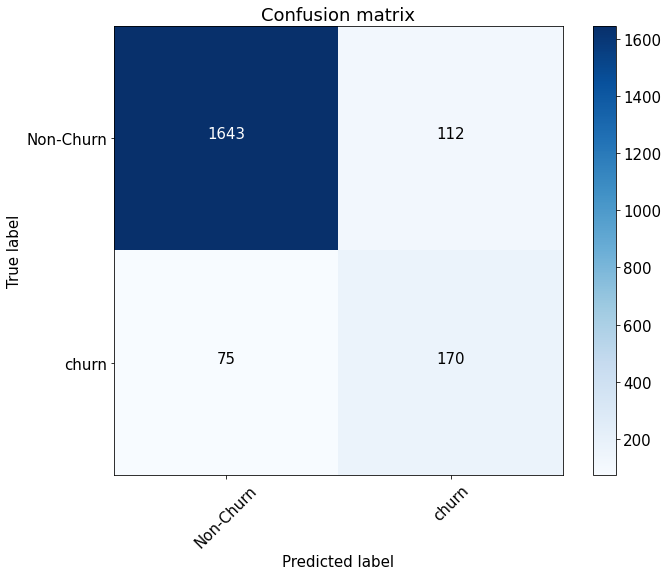

In [41]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [42]:
result_mean_roc_auc = roc_auc_score(y_test, preds)
# roc_auc_score(y_test, preds)
print(result_mean_roc_auc)

0.935161346589918


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

#### Модифицируем функцию get_user_embedding, чтобы считалась медиана.

In [43]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.mean(user_vector, 0)
    user_vector = np.median(user_vector, 0)
#     user_vector = np.max(user_vector, 0)
    return user_vector

In [44]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.18574445, 0.        , 0.        ,
       0.00658568, 0.1774538 , 0.02718805, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00516829,
       0.        , 0.        , 0.        , 0.        , 0.01975169,
       0.078239  , 0.        , 0.        , 0.        , 0.07264093])

In [45]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.000000,0.0,0.0,0.099811,0.163456,0.043026,0.000000,...,0.030584,0.007362,0.009224,0.042021,0.000000,0.000000,0.000000,0.000000,0.0,0.136337
1,u108690,0.0,0.0,0.135633,0.0,0.0,0.031439,0.071539,0.110910,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.062879,0.017796,0.016245,0.0,0.192903
2,u108339,0.0,0.0,0.159736,0.0,0.0,0.037721,0.079518,0.008800,0.006499,...,0.000000,0.000000,0.000000,0.014815,0.005444,0.000000,0.000000,0.000000,0.0,0.175913


In [46]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [47]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.000000,0.0,0.0,0.099811,0.163456,0.043026,0.000000,...,0.007362,0.009224,0.042021,0.000000,0.000000,0.000000,0.000000,0.0,0.136337,0
1,u108690,0.0,0.0,0.135633,0.0,0.0,0.031439,0.071539,0.110910,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.062879,0.017796,0.016245,0.0,0.192903,1
2,u108339,0.0,0.0,0.159736,0.0,0.0,0.037721,0.079518,0.008800,0.006499,...,0.000000,0.000000,0.014815,0.005444,0.000000,0.000000,0.000000,0.0,0.175913,1


In [48]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [49]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [50]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10521082, 0.00867219, 0.41714099, 0.63940539, 0.0354491 ,
       0.03161418, 0.06839417, 0.16498867, 0.11654278, 0.16920478])

In [51]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
result_median = 'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix])
print(result_median)

Best Threshold=0.313590, F-Score=0.669, Precision=0.650, Recall=0.690


Confusion matrix, without normalization
[[1664   91]
 [  77  168]]


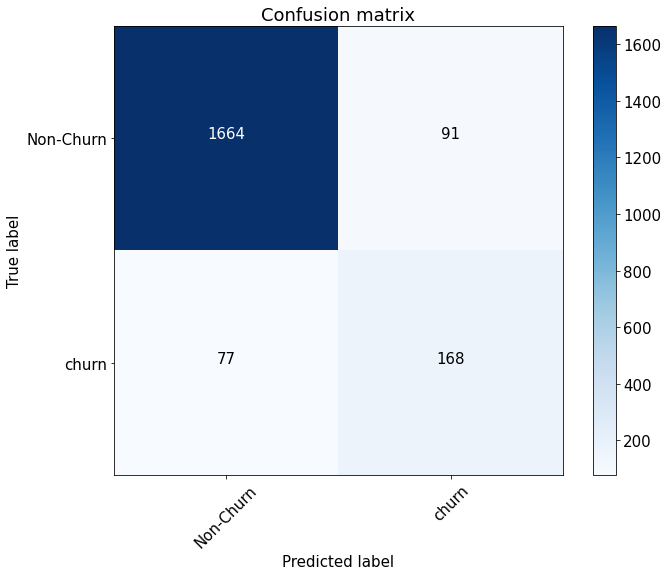

In [52]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [53]:
result_median_roc_auc = roc_auc_score(y_test, preds)
# roc_auc_score(y_test, preds)
print(result_median_roc_auc)

0.9407058549915693


#### Модифицируем функцию get_user_embedding через max

In [54]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.mean(user_vector, 0)
#     user_vector = np.median(user_vector, 0)
    user_vector = np.max(user_vector, 0)
    return user_vector

In [55]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.48584676, 0.        , 0.        ,
       0.04169273, 0.33160233, 0.31806144, 0.        , 0.03290902,
       0.0554616 , 0.        , 0.03043099, 0.66002542, 0.22032256,
       0.        , 0.11132953, 0.24000004, 0.        , 0.20926039,
       0.30099288, 0.        , 0.02084973, 0.        , 0.24671915])

In [56]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.594826,0.000000,0.000000,0.325446,0.356652,0.200444,0.100274,...,0.154412,0.243862,0.256352,0.198675,0.021049,0.000000,0.148084,0.000000,0.035969,0.286542
1,u108690,0.0,0.000000,0.332623,0.000000,0.000000,0.220172,0.134291,0.279502,0.166830,...,0.060195,0.013770,0.125334,0.000000,0.011097,0.264240,0.086322,0.061127,0.000000,0.352211
2,u108339,0.0,0.018176,0.242381,0.016444,0.024827,0.335018,0.163890,0.135922,0.069941,...,0.026222,0.000000,0.027995,0.101268,0.178819,0.178309,0.000000,0.068981,0.019866,0.233012


In [57]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [58]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.594826,0.000000,0.000000,0.325446,0.356652,0.200444,0.100274,...,0.243862,0.256352,0.198675,0.021049,0.000000,0.148084,0.000000,0.035969,0.286542,0
1,u108690,0.0,0.000000,0.332623,0.000000,0.000000,0.220172,0.134291,0.279502,0.166830,...,0.013770,0.125334,0.000000,0.011097,0.264240,0.086322,0.061127,0.000000,0.352211,1
2,u108339,0.0,0.018176,0.242381,0.016444,0.024827,0.335018,0.163890,0.135922,0.069941,...,0.000000,0.027995,0.101268,0.178819,0.178309,0.000000,0.068981,0.019866,0.233012,1


In [59]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [60]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [61]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.31375156, 0.00180814, 0.72735933, 0.09914204, 0.00453647,
       0.05713078, 0.11994526, 0.47622168, 0.03354553, 0.07524621])

In [62]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
result_max = 'Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix])
print(result_max)

Best Threshold=0.319551, F-Score=0.787, Precision=0.756, Recall=0.820


Confusion matrix, without normalization
[[1690   65]
 [  45  200]]


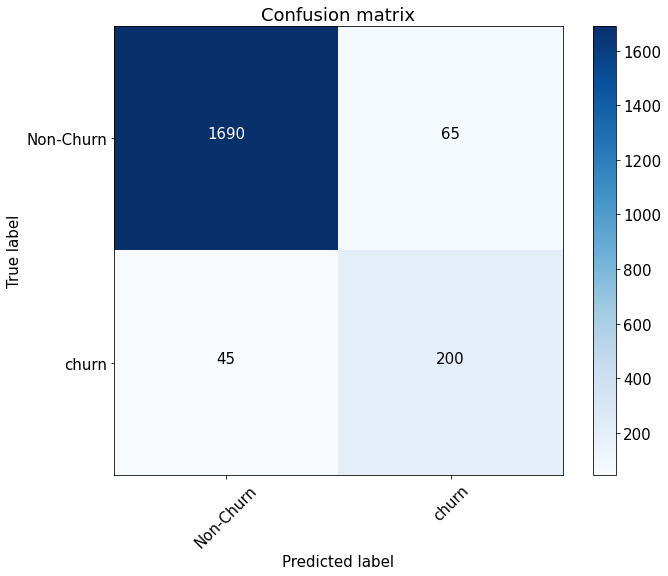

In [63]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [64]:
result_max_roc_auc = roc_auc_score(y_test, preds)
# roc_auc_score(y_test, preds)
print(result_max_roc_auc)

0.9772800744229315


#### Единая таблица по качеству разных методов

In [65]:
print(f'Mean:\n{result_mean}, ROC_AUC = {result_mean_roc_auc}\n')
print(f'Median:\n{result_median}, ROC_AUC = {result_median_roc_auc}\n')
print(f'Max:\n{result_max}, ROC_AUC = {result_max_roc_auc}')

Mean:
Best Threshold=0.265988, F-Score=0.648, Precision=0.604, Recall=0.698, ROC_AUC = 0.935161346589918

Median:
Best Threshold=0.313590, F-Score=0.669, Precision=0.650, Recall=0.690, ROC_AUC = 0.9407058549915693

Max:
Best Threshold=0.319551, F-Score=0.787, Precision=0.756, Recall=0.820, ROC_AUC = 0.9772800744229315
